# Image Segmentation on Indian Driving Dataset

By [Akshaj Verma](https://akshajverma.com)

In [1]:
import pathlib
from tqdm.notebook import tqdm

import cv2
from PIL import Image

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler


from sklearn.metrics import classification_report, confusion_matrix

In [2]:
np.random.seed(0)
torch.manual_seed(0)

In [3]:
%matplotlib inline
sns.set_style('darkgrid')

## Define Paths and Set GPU

Let's define the path for our data.

In [4]:
ROOT_PATH = "../../../data/computer_vision/image_segmentation/idd-lite/idd20k_lite/"

train_images_path = ROOT_PATH + "leftImg8bit/train/"
train_labels_path = ROOT_PATH + "gtFine/train/"


val_images_path = ROOT_PATH + "leftImg8bit/val/"
val_labels_path = ROOT_PATH + "gtFine/val/"

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

We're using => cuda


## Visualize Data

### Training image

Shape of the image is:  (227, 320, 3) 




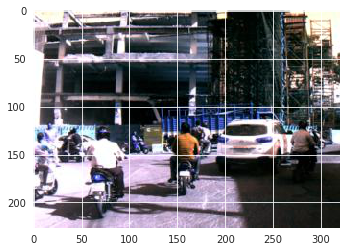

In [6]:
img = cv2.imread(train_images_path + "0/024541_image.jpg", 1)
print("Shape of the image is: ", img.shape, "\n\n")
plt.imshow(img)

### Histogram of image

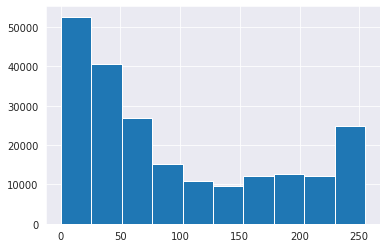

In [7]:
plt.hist(img.flatten())
plt.show()

### Training label

In [8]:
lol = Image.open(str(train_labels_path + "0/024541_label.png"))

In [9]:
np.array(lol)

array([[6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

Shape of the label is:  (227, 320, 3) 




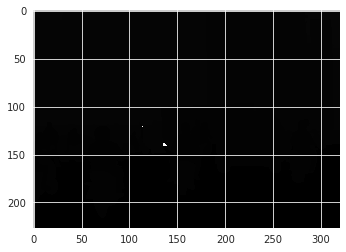

In [10]:
lbl = cv2.imread(train_labels_path + "0/024541_label.png", 1)
print("Shape of the label is: ", lbl.shape, "\n\n")
plt.imshow(lbl)

### Histogram of label

In [11]:
lbl_in_image = np.nonzero(np.bincount(lbl.flatten()))[0]
lbl_in_image

array([  0,   2,   3,   4,   5,   6, 255])

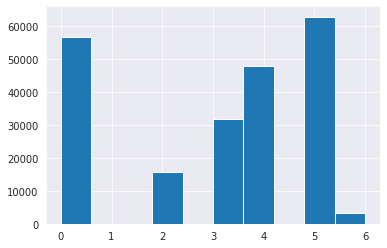

In [12]:
plt.hist(lbl.flatten(), range=[0, 6])
plt.show()

In [13]:
def enhance_seg_mask(img_path):
    img = cv2.imread(img_path, 0)
    img = img*41
    
    return img

In [14]:
enhanced_lbl = enhance_seg_mask(train_labels_path + "0/024541_label.png")
enhanced_lbl

array([[246, 246, 246, ..., 246, 246, 246],
       [246, 246, 246, ..., 246, 246, 246],
       [246, 246, 246, ..., 246, 246, 246],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

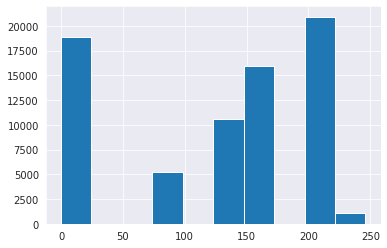

In [15]:
plt.hist(enhanced_lbl.flatten())
plt.show()

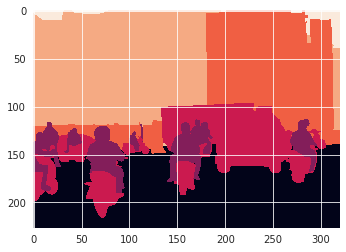

In [16]:
plt.imshow(enhanced_lbl)

## Data Preprocessing

### Create Transforms

In [38]:
IMAGE_LABEL_SIZE = 224

image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((IMAGE_LABEL_SIZE, IMAGE_LABEL_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
    ]),
    "test": transforms.Compose([
        transforms.Resize((IMG_LABEL_SIZE, IMG_LABEL_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
    ])
}

### Create Dataset

In [39]:
root_path = pathlib.Path(ROOT_PATH)

print("Root path: ", root_path)
print("")

# train paths
train_images_path = root_path.joinpath("leftImg8bit").joinpath("train")
train_labels_path = root_path.joinpath("gtFine").joinpath("train")

print("Train Images path: ", train_images_path)
print("Train Labels path: ", train_labels_path)
print("")

# test paths
test_images_path = root_path.joinpath("leftImg8bit").joinpath("val")
test_labels_path = root_path.joinpath("gtFine").joinpath("val")

print("Test Images path: ", test_images_path)
print("Test Labels path: ",test_labels_path)
print("")

Root path:  ../../../data/computer_vision/image_segmentation/idd-lite/idd20k_lite

Train Images path:  ../../../data/computer_vision/image_segmentation/idd-lite/idd20k_lite/leftImg8bit/train
Train Labels path:  ../../../data/computer_vision/image_segmentation/idd-lite/idd20k_lite/gtFine/train

Test Images path:  ../../../data/computer_vision/image_segmentation/idd-lite/idd20k_lite/leftImg8bit/val
Test Labels path:  ../../../data/computer_vision/image_segmentation/idd-lite/idd20k_lite/gtFine/val



In [45]:
class DatasetIDD(Dataset):
    def __init__(self, images_path, labels_path, image_transform, img_lbl_size):
        super(DatasetIDD, self).__init__()
        self.images_path = pathlib.Path(images_path)
        self.labels_path = pathlib.Path(labels_path)
        
        self.img_lbl_size = img_lbl_size
        self.transform = image_transform
        
        self.img_file_paths = [file for file in images_path.rglob("**/*.jpg")]
        self.lbl_file_paths = [file for file in labels_path.rglob("**/*.png") if len(file.parts[-1].split("_")) == 2 ]
        
    def __getitem__(self, idx):
        img_path = str(self.img_file_paths[idx])
        lbl_path = str(self.lbl_file_paths[idx])
        
        img = Image.open(img_path)
        img = self.transform(img)
        
        lbl = Image.open(lbl_path)
        lbl = lbl.resize((self.img_lbl_size, self.img_lbl_size))
        lbl = torch.from_numpy(np.array(lbl)).float()
        
        return img, lbl
    
    def __len__(self):
        return len(self.img_file_paths)

#### Train Dataset

In [46]:
train_dataset = DatasetIDD(images_path=train_images_path, labels_path=train_labels_path, image_transform=image_transforms["train"], img_lbl_size=IMAGE_LABEL_SIZE)
train_loader = DataLoader(dataset=train_dataset, shuffle=False, batch_size=8)

#### Test Dataset

In [52]:
test_dataset = DatasetIDD(images_path=test_images_path, labels_path=test_labels_path, image_transform=image_transforms["test"], img_lbl_size=IMAGE_LABEL_SIZE)
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=1)

### Sanity Check

In [58]:
print("Shape of image from train-loader = ", next(iter(train_loader))[0].shape)
print("Shape of label from train-loader = ", next(iter(train_loader))[1].shape)

print("\nShape of image from test-loader = ", next(iter(train_loader))[0].shape)
print("Shape of label from test-loader = ", next(iter(train_loader))[1].shape)

Shape of image from train-loader =  torch.Size([8, 3, 224, 224])
Shape of label from train-loader =  torch.Size([8, 224, 224])

Shape of image from test-loader =  torch.Size([8, 3, 224, 224])
Shape of label from test-loader =  torch.Size([8, 224, 224])


## Model

[tensor([[[[-0.5596, -1.4158, -0.6794,  ..., -1.6384, -1.6727, -1.7754],
           [-0.7822, -1.6898, -0.7993,  ..., -1.4329, -0.9534, -1.8439],
           [-0.4226, -1.2617, -1.5014,  ..., -1.6555, -1.0733, -1.6898],
           ...,
           [ 0.0398,  0.0741,  0.0569,  ..., -0.1828, -0.1657, -0.1657],
           [ 0.0398,  0.0741,  0.0569,  ..., -0.1828, -0.1657, -0.1657],
           [ 0.0398,  0.0741,  0.0741,  ..., -0.1828, -0.1657, -0.1657]],
 
          [[-0.2325, -1.1253, -0.4076,  ..., -1.4580, -1.5105, -1.6155],
           [-0.4601, -1.4055, -0.5476,  ..., -1.2129, -0.7752, -1.7381],
           [-0.0749, -0.9678, -1.2479,  ..., -1.4580, -0.8978, -1.5280],
           ...,
           [ 0.1352,  0.1702,  0.1527,  ..., -0.1800, -0.1625, -0.1625],
           [ 0.1352,  0.1702,  0.1527,  ..., -0.1800, -0.1625, -0.1625],
           [ 0.1352,  0.1702,  0.1702,  ..., -0.1800, -0.1625, -0.1625]],
 
          [[ 0.1825, -0.7238, -0.0267,  ..., -1.0898, -1.0898, -1.1421],
           [-